## 1. Searching for insights inside HTML files

<p>In this notebook, we will generate investing insight by applying <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">sentiment analysis</a> on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>. Using this <a href="https://en.wikipedia.org/wiki/Natural_language_processing">natural language processing</a> technique, we can understand the emotion behind the headlines and predict whether the market <em>feels</em> good or bad about a stock. It would then be possible to make educated guesses on how certain stocks will perform and trade accordingly. (And hopefully, make money!)</p>
<p><img src="https://assets.datacamp.com/production/project_611/img/fb_headlines.png" alt="Facebook headlines from FINVIZ.com"></p>


In [1]:
# Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    #this is the path to the file. Don't touch!
    table_path = "datasets/"+table_name
    
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r')
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file)
    
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id="news-table")
   
    # Add the table to our dictionary
    html_tables[table_name] = html_table


## 2. Exploring the files
<ul>
<li>Explore the headlines table here in this notebook!</li>
</ul>


In [2]:
# Read one single day of headlines 
tsla = html_tables['tsla_22sep.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')


# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'{i}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    # The following exits the loop after three rows to prevent spamming the notebook, do not touch
    if i == 3:
        break

0:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
1:
Broadcoms Stock Looks Like a Winner
09:30PM  
2:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
3:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3.Extracting all the news headlines

In [3]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text()
        headline = x.a.get_text()
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, headline])


## 4. NLTK think like a financial journalist
<p>Adding some new words and sentiment values to our lexicon.</p>

In [4]:
# NLTK VADER for sentiment analysis
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)


## 5. BREAKING NEWS: NLTK Crushes Sentiment Estimates
<p>VADER in action </p>

In [5]:
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']
# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)
# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]
# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)
# Join the DataFrames
scored_news = pd.concat([scored_news, scores_df], axis=1)
# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date
scored_news.head()

,ticker,date,time,headline,compound,neg,neu,pos
0,fb,2019-01-04,06:22PM,"Facebook, Apple, Netflix, Amazon and Alphabet ...",0.4767,0.0,0.631,0.369
1,fb,2019-01-04,05:15PM,Earnings Reports for the Week of Jan. 7-11 (BB...,0.0000,0.0,1.000,0.000
2,fb,2019-01-04,04:55PM,COLUMN-Commentary: 2019 will be the year of mo...,0.0000,0.0,1.000,0.000
3,fb,2019-01-04,04:53PM,3 Tech Trends to Watch in 2019,0.0000,0.0,1.000,0.000
4,fb,2019-01-04,04:30PM,Will Denver's tech growth continue in 2019?,0.3818,0.0,0.698,0.302


## 6. Plot all the sentiment in subplots
<p> Plotting the time series for the stocks we have.</p>

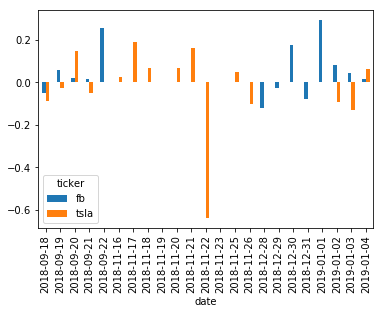

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

# Group by date and ticker columns from scored_news and calculate the mean
mean_c = scored_news.groupby(['date', 'ticker']).mean()
# Unstack the column ticker
mean_c = mean_c.unstack(level=1)
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound', axis=1)
# Plot a bar chart with pandas
mean_c.plot.bar();

## 7. Cleaning the duplicates
<p>Cleaning duplicates</p>

In [7]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()
# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(['ticker', 'headline'])
# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean.headline.count()
# Compare before and after
print(num_news_before)
print(num_news_after)

500
476


## 8. Sentiment on one single trading day and stock

In [10]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
#print(single_day)
# Cross-section the fb row
single_day = single_day.loc['fb']
#print(single_day)
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-03']
#print(single_day)
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time
#print(single_day)
#print(single_day.shape)
# Set the index to time and sort by it
single_day.set_index('time', inplace=True)
single_day=single_day.sort_index(ascending=True)
single_day

time
06:00:00    Why Internet Censorship Doesnt Work and Never ...
08:04:00    3 Big Stock Charts for Thursday: Medtronic, Fa...
09:07:00    The Zacks Analyst Blog Highlights: Facebook, W...
09:12:00    Why The FAANGs Are Crucial To A 2019 Market Rally
09:34:00    Apple warning stoking fears of slowdown in Chi...
09:48:00                    Stock Market News For Jan 3, 2019
09:58:00                                    Facebook Falls 3%
10:08:00    Mark Zuckerberg Halts Stock Sales as Facebook ...
10:21:00    Facebook Under Fire for Collecting Data From A...
10:42:00    Why Netflix Stock Will Rise Back Above $300 In...
12:25:00    3 Great Reasons You Should Be Bullish on Twili...
13:31:00             Take the Money And Run From Twilio Stock
13:36:00    What's Next For Apple (AAPL) After It Slashed ...
15:14:00    Zuckerberg Paused His Selling of Facebook Shar...
15:26:00        Is Facebook Stock the Best FANG Stock to Buy?
16:10:00    Google Stock Upgraded, Viewed As 'Most Defensi...
17:

## 9. Visualize the single day

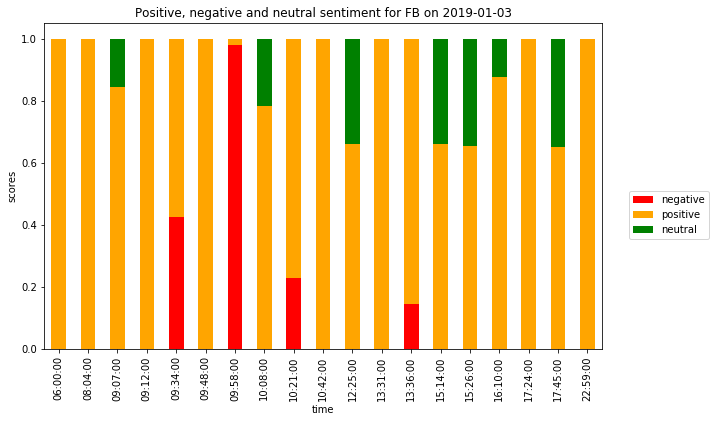

In [9]:
TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red", "orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['headline', 'compound'], axis=1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = TITLE, 
                  color = COLORS)
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");